In [56]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [57]:
df = pd.read_csv('ucs_rqd_data.csv')

In [58]:
df.head()

,bh_no,Depth,easting,northing,R.L,Condition,UCS,RQD
0,1,8.25,276816.883,2114086.734,4.25,Soak,8.52,0.0
1,1,11.25,276816.883,2114086.734,1.25,Soak,29.61,39.0
2,1,14.25,276816.883,2114086.734,-1.75,Unsoak,32.95,54.0
3,1,17.25,276816.883,2114086.734,-4.75,Soak,14.70,23.0
4,1,20.25,276816.883,2114086.734,-7.75,Soak,1.68,66.0


Text(0,0.5,'Frequency')

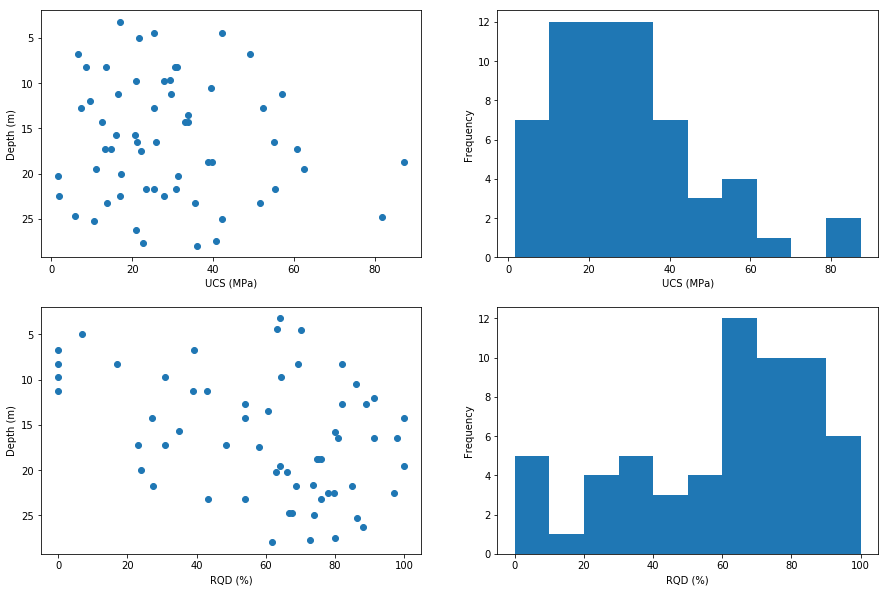

In [59]:
# Descriptive statistics
fig = plt.figure()
fig.set_size_inches(15,10)

ax1 = plt.subplot(221)
ax1.scatter(df['UCS'],df['Depth'])
ax1.set_ylabel('Depth (m)')
ax1.set_xlabel('UCS (MPa)')
ax1.invert_yaxis()

ax2 = plt.subplot(222)
ax2.hist(df['UCS'])
ax2.set_xlabel('UCS (MPa)')
ax2.set_ylabel('Frequency')

ax3 = plt.subplot(223)
ax3.scatter(df['RQD'],df['Depth'])
ax3.set_ylabel('Depth (m)')
ax3.set_xlabel('RQD (%)')
ax3.invert_yaxis()

ax4 = plt.subplot(224)
ax4.hist(df['RQD'])
ax4.set_xlabel('RQD (%)')
ax4.set_ylabel('Frequency')

In [60]:
# check the correlation
stats.pearsonr(df['UCS'],df['Depth'])[0]

0.10293909922681589

Only 10% of the variability of UCS can be explained by depth

In [61]:
# correlation between RQD and Depth
stats.pearsonr(df['RQD'],df['Depth'])[0]

0.38000786574157075

38% of the varibility in RQD can be explained by depth

In [62]:
stats.pearsonr(df['UCS'],df['RQD'])[0]

0.05621456857887025

We can say RQD and UCS are independent variables since there is no correlation between them

Rock Mass Rating
-----

In this section, we will be evalualting the RMR values based on given UCS and RQD values only. 

In [63]:
data = df.copy()

def pearson_coeff(x,y):
    x = np.asarray(x)
    y = np.asarray(y)
    
    xmean = np.mean(x)
    ymean = np.mean(y)
    std_x = np.std(x)
    std_y = np.std(y)
    
    xi = [(val-xmean)/std_x for val in x] 
    yi = [(val-ymean)/std_y for val in y]
    
    return sum(xi*np.transpose(yi))/len(x)

def leastSquares(xs,ys):
    r = pearson_coeff(xs,ys)
    slope = r*(np.std(ys)/np.std(xs))
    intercept = np.mean(ys)-slope*np.mean(xs)
    return slope,intercept

def fitLine(xs,slope,intercept):
    fit_xs = np.sort(xs)
    fit_ys = fit_xs*slope+intercept
    return fit_xs,fit_ys

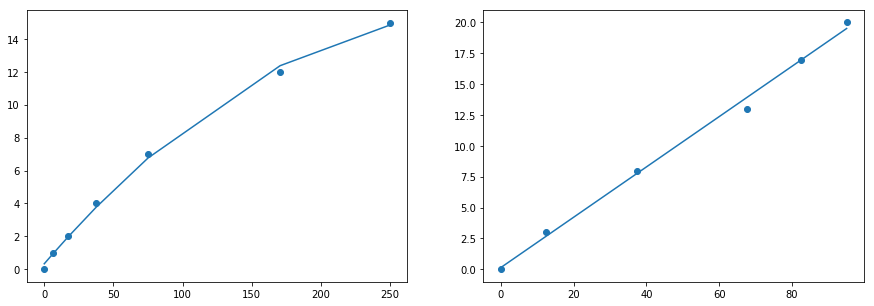

In [64]:
# IS code tables
# linear model for predicting the ucs rating
ucs = np.array([0,6,17.5,37.5,75,170.5,250])
ucs_rating= [0,1,2,4,7,12,15]

d1 = dict(ucs=ucs,rating=ucs_rating,ucs2=ucs**2)
ucs_df = pd.DataFrame(d1)
ucs_formula = 'rating~ucs+ucs2'
ucs_result = smf.ols(ucs_formula,data=ucs_df).fit()

# linear model for predicting RQD rating
rqd = [95,82.5,67.5,37.5,12.5,0]
rqd_rating = [20,17,13,8,3,0]

d2 = dict(rqd=rqd,rating=rqd_rating)
rqd_df = pd.DataFrame(d2)
rqd_formula = 'rating~rqd'
rqd_result = smf.ols(rqd_formula,data=rqd_df).fit()


## Plotting
figure = plt.figure()
figure.set_size_inches(15,5)

ax1 = plt.subplot(121)
ax1.scatter(ucs,ucs_rating)
ax1.plot(ucs,ucs_result.predict())

ax2 = plt.subplot(122)
ax2.scatter(rqd,rqd_rating)
ax2.plot(rqd,rqd_result.predict())


In [65]:
ucs_result.rsquared,rqd_result.rsquared

(0.9980304114504743, 0.9960780195363895)

Evaluating the RMR as per standard codes

In [66]:
data['ucs'] = data['UCS']
data['ucs2'] = data['UCS']**2

data['rqd'] = data['RQD']

data['ucs_rating'] = ucs_result.predict(data)
data['rqd_rating'] = rqd_result.predict(data)
data['rmr'] = (data['ucs_rating']+data['rqd_rating'])/35*100

In [67]:
data[['Depth','easting','northing','R.L','UCS','RQD','rmr']].head()

,Depth,easting,northing,R.L,UCS,RQD,rmr
0,8.25,276816.883,2114086.734,4.25,8.52,0.0,3.697130
1,11.25,276816.883,2114086.734,1.25,29.61,39.0,31.935841
2,14.25,276816.883,2114086.734,-1.75,32.95,54.0,41.511956
3,17.25,276816.883,2114086.734,-4.75,14.70,23.0,18.755503
4,20.25,276816.883,2114086.734,-7.75,1.68,66.0,40.274700


Based on the RMR values, we will plot the rock profile. This will give an idea about the grade of rock found at different location and depths.

Text(0,0.5,'Depth (m)')

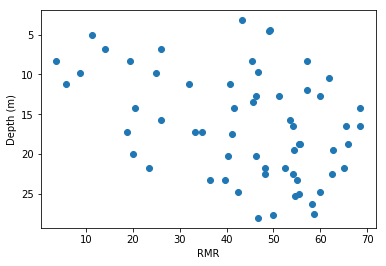

In [68]:
plt.scatter(data['rmr'],data['Depth'])
plt.gca().invert_yaxis()
plt.xlabel('RMR')
plt.ylabel('Depth (m)')

In [69]:
stats.pearsonr(data['rmr'],data['Depth'])[0]

0.3865313256910861

Clearly the linear model is not a better model from the graph above. Hence we will use non-linear model to predict the RMR values

Decision Tree
-----

In [70]:
tree_dataset = data[['Depth','easting','northing','rmr']]
tree_dataset.head()
easting = min(tree_dataset['easting'])
northing = min(tree_dataset['northing'])
tree_dataset['X'] = tree_dataset['easting'] - easting
tree_dataset['Y'] = tree_dataset['northing'] - northing

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [71]:
tree_dataset.head()

,Depth,easting,northing,rmr,X,Y
0,8.25,276816.883,2114086.734,3.697130,8.104,19.71
1,11.25,276816.883,2114086.734,31.935841,8.104,19.71
2,14.25,276816.883,2114086.734,41.511956,8.104,19.71
3,17.25,276816.883,2114086.734,18.755503,8.104,19.71
4,20.25,276816.883,2114086.734,40.274700,8.104,19.71


**Borehole Layout**

Text(0,0.5,'northing')

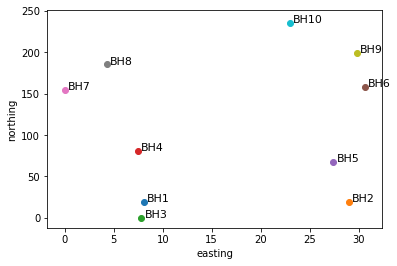

In [72]:
x = tree_dataset['X'].unique()
y = tree_dataset['Y'].unique()

for i,(x,y)  in enumerate(zip(x,y)):
    plt.scatter(x,y)
    text = 'BH'+str(i+1)
    plt.text(x+0.3,y+0.3,text,fontsize=11)

plt.xlabel('easting')
plt.ylabel('northing')

In [73]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
X_tree = tree_dataset[['Depth','X','Y']].values
Y_tree = tree_dataset['rmr'].values
tree.fit(X_tree,Y_tree)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [74]:
# Prediction
tree.predict(np.array([21,8,211]).reshape(1,3))

array([62.48824496])

Plotting the RMR values along a section
-----

In [75]:
resolution = 40

# Northing
y_cors = tree_dataset['Y'].values
Y_cors = np.linspace(min(y_cors),max(y_cors),num=resolution)
# depth
Z_cors = np.linspace(0,30,num=resolution)
# easting 
x_cors = tree_dataset['X'].values
X_cors = np.linspace(min(x_cors),max(x_cors),num=resolution)

X_grid,Y_grid,Z_grid = np.meshgrid(X_cors,Y_cors,Z_cors) 

rmr_tree = np.zeros((len(X_grid),len(Y_grid),len(Z_grid)))
for x in range(resolution):
        for y in range(resolution):
            for z in range(resolution):
                predict = np.array([Z_cors[z],X_cors[x],Y_cors[y]]).reshape(1,3)
                rmr_tree[z,x,y] = tree.predict(predict)
            

In [76]:
coordinate = 34
northing = X_cors[coordinate]
northing

26.683025641041475

C:\Users\Admin\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label'
  s)


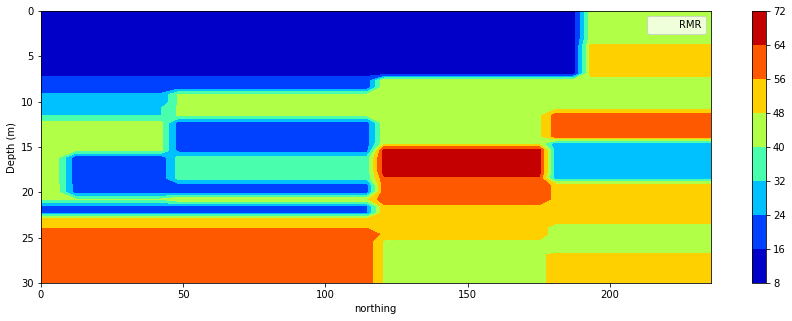

In [77]:
fig = plt.figure(figsize=(15,5))

# rmr_tree[z,x,y]
plot = rmr_tree[:,coordinate,:]

ax = fig.add_subplot(111)

Y1_grid,Z1_grid = np.meshgrid(Y_cors,Z_cors)

contour = ax.contourf(Y1_grid,Z1_grid,plot,cmap=plt.get_cmap('jet'),label='RMR')
fig.colorbar(contour,ax=ax)
ax.invert_yaxis()
ax.set_xlabel('northing')
ax.set_ylabel('Depth (m)')
ax.legend(['RMR'])

this model seems far better model than the linear one because it is classifying the results quite well based on the given features. however we can still improve the model using a different algorithm.

Random Forest to improve the above model
---

In [78]:
from sklearn.ensemble import RandomForestRegressor
randomForest = RandomForestRegressor(n_estimators = 10)
X_tree = tree_dataset[['Depth','X','Y']].values
Y_tree = tree_dataset['rmr'].values
randomForest.fit(X_tree,Y_tree)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [79]:
# Prediction
randomForest.predict(np.array([21,8,211]).reshape(1,3))

array([50.0131161])

In [80]:
resolution = 40

# Northing
y_cors = tree_dataset['Y'].values
Y_cors = np.linspace(min(y_cors),max(y_cors),num=resolution)
# depth
Z_cors = np.linspace(0,30,num=resolution)
# easting 
x_cors = tree_dataset['X'].values
X_cors = np.linspace(min(x_cors),max(x_cors),num=resolution)

X_grid,Y_grid,Z_grid = np.meshgrid(X_cors,Y_cors,Z_cors) 

rmr_tree = np.zeros((len(X_grid),len(Y_grid),len(Z_grid)))
for x in range(resolution):
        for y in range(resolution):
            for z in range(resolution):
                predict = np.array([Z_cors[z],X_cors[x],Y_cors[y]]).reshape(1,3)
                rmr_tree[z,x,y] = randomForest.predict(predict)

In [81]:
#Plotting along a section
# I am interested to see the profile at easting around 25 to 26 
coordinate = 34
northing = X_cors[coordinate]
northing

26.683025641041475

C:\Users\Admin\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label'
  s)


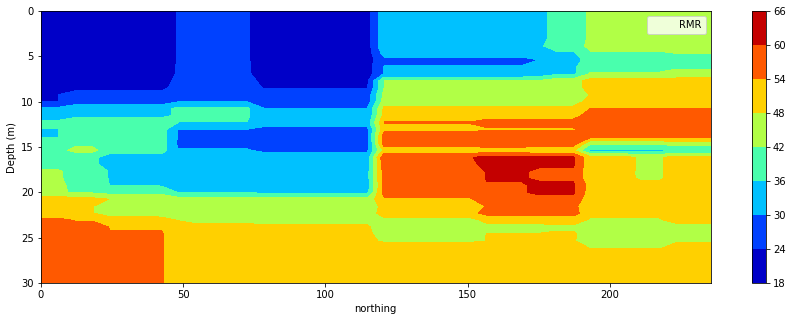

In [82]:
fig = plt.figure(figsize=(15,5))

# rmr_tree[z,x,y]
plot = rmr_tree[:,coordinate,:]

ax = fig.add_subplot(111)

Y1_grid,Z1_grid = np.meshgrid(Y_cors,Z_cors)

contour = ax.contourf(Y1_grid,Z1_grid,plot,cmap=plt.get_cmap('jet'),label='RMR')
fig.colorbar(contour,ax=ax)
ax.invert_yaxis()
ax.set_xlabel('northing')
ax.set_ylabel('Depth (m)')
ax.legend(['RMR'])

This gives a better model than the previous model which was based on decision tree.